We want to test the performance of a QIF framework for non-Markovian, covariance stationary process using non-linear quantised measurements.

#### TRUE DYNAMICS

We will use AKF coefficients for the true test cases defined in the linear regime.
- true_rk_quant = 0.001^2
- QKF is fed AKF (optimal) sigma
- OKF is tuned for a new R

#### PREAMBLE COMMANDS ####

In [1]:
import sys
sys.path.append('../../../')

#### Local KF Tuning Helpers ####
from data_tools.data_risk_analysis import build_risk_dict, riskmapdata
from data_tools.load_raw_cluster_data import LoadExperiment

#### Local QIF Filter and Helper Functions ####
from qif.qif import qif as qif
from qif.common import generate_AR, noisy_z, projected_msmt, qkf_state_err, normalise
from ls.common import doLSF_forecast

#### Local Plotting Tools ####
from plot_tools.fig_preamble import *
from plot_tools.plot_helper_funcs import cm2inch

#### Matplotlib & Numpy ####
import numpy as np
import matplotlib as mpl
mpl.rc('font', size=8)
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.gridspec as gridspec


#### Global Plotting and Saving Commands ####

############ Saving Commands #########

ver=0
datapath = '../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
savefig = './analysis_figs'
figname = 'tc_24_linear_regime_2_'

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


#### LOW Q REGIME - AR(2) PROCESS

We need to satisfy the following constraints 

For stationarity:
    (a) ph1 + ph2 < 1
    (b) ph1 - ph2 < 1
    (c) phi2| < 1

In [2]:
# ######## Covariance Stationary, MS Ergoic AR(2) Process#######
# # Stationary ARMA: http://matthieustigler.github.io/Lectures/Lect2ARMA.pdf

# ar1 = -0.02# 
# ar2 = +0.968
# q_regime.append(np.asarray([ar1, ar2]))

#### HIGH Q REGIME - AR(q) PROCESS USING LEARNED LSF WEIGHTS

In [3]:
# We want to load a high order AR(q) model where we know that underlyign truth is stationary.

test_case = 24
variation_scan = [1, 2, 3, 4]

#### Noise Parameters

In order to generate our true process, we will take tuned parameters from the linear AKF optimisation procedure. We retain an additional measurement noise term - which is white noise added prior to quantisation.

In [4]:
######## Msmt Noise Strength Prior to Quantisation
true_rk_quant = 0.001**2
####

#### Set up of Algorithm Parameters (QKF, LSF)

In [5]:
###### Number of data points and initial points to exclude (burnin) #####
num = 2050
burn_in = 0

###### AR Process Initialisation #####
# we need phases to accumulate from 0 to pi. So our process is no longer mean zero.
mean_noise = 0.5*np.pi

###### Bayes Risk Runs ######
runs = 50
num_rand_r = 100
space_size = np.arange(-2, 5) # machine precision + expect R to be higher than in the linear regime

########### LSF ##############
pick_alpha=0.1
n_predict = 50
n_train=num-n_predict
num_of_iterGD = 50
n_testbefore=50
########### KF ##############
p0init = 1000 # set same as AKF /LSF

In [6]:
from scipy.signal import periodogram

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def func_x0(space_size):
    '''
    Returns random dim =2 arrays from a parameter space defined by space_size
    [Helper function for Bayes Risk mapping]
    '''
    maxindex = space_size.shape[0]-1
    ind = int(np.random.uniform(low=0, high=maxindex))
    exponent = space_size[ind]
    return np.random.uniform(0,1)*(10.0**exponent)

####  QIF BR MAP

In [7]:
for idx_q_regime in xrange(len(variation_scan)):
    
    experiment = LoadExperiment(test_case, variation_scan[idx_q_regime], 
                                LKFFB_load ='No',
                                LSF_load='No',
                                AKF_load='Yes', 
                                AKF_path=datapath,
                                GPRP_load='No')
    
    z_states_errs_= np.zeros((num_rand_r, runs, num))
    norm_z_states_= np.zeros((num_rand_r, runs, num))
    macro_truth = np.zeros((num_rand_r, runs, num))
    
    # We extract tuned parameters from linear regimeto specify the dynamical model

    riskmapexpt = build_risk_dict(experiment)

    tuned_sigma, tuned_R = riskmapdata(riskmapexpt['AKF'][0], 
                                   riskmapexpt['AKF'][2], 
                                   riskmapexpt['AKF'][1],
                                   maxforecaststps=50,
                                   maxstateeststps=50)[0:2]

    print("Optimal KF pair from linear regime", tuned_sigma[0], tuned_R[0])
    
    ######### Tune Kalman R ############
    
    random_hyperparams_list = np.zeros((num_rand_r, 2))
    rand_r=np.zeros(num_rand_r)
    
    for idx_r in xrange(num_rand_r):
        
        # We make a truth bank of all f_n generated in the linear msmt regime
        shape = experiment.AKF_macro_truth.shape
        truth_bank = experiment.AKF_macro_truth.reshape(shape[0]*shape[1], shape[2]) # collapsed

        # We extract the the AR(q) regime of coefficients
        AKF_weights = experiment.AKF_weights
        order = AKF_weights.shape[0]
        n_start_at=n_train - order + 1

        # We store placeholders for analysis
        x_true_dynamics = np.zeros((runs, order, num))
        gain_true_dynamics = np.zeros((runs, order, num))
        truths_ = np.zeros((runs, num))
        err_true_dynamics = np.zeros((runs, num))
        
        random_hyperparams_list[idx_r, 0] = tuned_sigma[0]*func_x0(np.arange(2, 9)) 
        random_hyperparams_list[idx_r, 1] = func_x0(space_size)


        ######### Make an ensemble of QIF experiments for same trial of R ############

        for idx_run in xrange(runs):

            # Pick truth for one run
            pickone = int(np.random.uniform(low=0, high = int(truth_bank.shape[0]-1)))
            true_x = truth_bank[pickone, :] + mean_noise 
            truths_[idx_run, :] = true_x # this is mean 0.5 pi 

            # Our data set is a noisy f_n sequence which incurs a non linear msmt action + AGWN prior to quantisation 
            f_n_dataset = true_x + experiment.AKF_msmt_noise_variance*np.random.standard_normal(true_x.shape)
            noisy_z_ = noisy_z( f_n_dataset, true_rk_quant) # z is mean zero

            # Generate single shot outcomes dataset
            y_signal = projected_msmt(noisy_z_)

            # Run QIF using AKF Dynamics 
            predictions, W, x_hat, P_hat, err_true_dynamics[idx_run, :] = qif('AKFdynamics', y_signal, 
                                                                              AKF_weights, 
                                                                              random_hyperparams_list[idx_r, 0], 
                                                                              random_hyperparams_list[idx_r, 1],
                                                                              n_train=n_train, 
                                                                              n_testbefore=n_predict, 
                                                                              n_predict=n_predict, 
                                                                              p0=p0init, skip_msmts=1,  save='No')
            # Store run for this experiment
            x_true_dynamics[idx_run, :, :] = x_hat[:,0,:]
            gain_true_dynamics[idx_run, :, :] = W[:,0,:]


        ######### Calculate Bayes Risk with respect to z for each variation, R ############
        z_true_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_true_dynamics[:, 0, 0:num]])

        ######### Calculate Bayes Risk for predicting mean z = 0.5cos(f_n) == 0  ############
        truths_z = np.asarray([noisy_z(sequence, 0.) for sequence in truths_[:, 0:num]])
        predict_one = np.mean((truths_z)**2, axis=0)

        ######### Normalise Bayes Risk  ############
        # ensure this is consistently calculated with linear regime. 
        z_states_errs_[idx_r, :, :] = qkf_state_err(z_true_dynamics[:, :], truths_z)
        norm_z_states_[idx_r, :, :] = z_states_errs_[idx_r, :, :] / predict_one
        macro_truth[idx_r, :, :] = truths_z
    
    ######### Save BR Map for experiment  ############
    
    filename = 'test_case_'+str(test_case)+'_var_'+str(variation_scan[idx_q_regime])+'BR_QKF_Map.npz'
    
    np.savez(datapath+filename, 
             random_hyperparams_list=random_hyperparams_list, 
             macro_truth=macro_truth, 
             macro_prediction_errors=z_states_errs_[:,:,n_train-n_testbefore:n_train],
             macro_forecastng_errors=z_states_errs_[:,:,n_train:],
             norm_z_states_=norm_z_states_)

AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 1
('Optimal KF pair from linear regime', 0.0037524869935435246, 3.3138177739302023e-05)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 2
('Optimal KF pair from linear regime', 0.262457340065538, 0.0067322345039353615)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 3
('Optimal KF pair from linear regime', 0.00047667030731105519, 9.2841378067634746e-08)
AKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 4
('Optimal KF pair from linear regime', 0.0004214627027849767, 6.0364178214963457e-08)


In [8]:
case_labels = ['(a)', '(b)', '(c)', '(d)']
ALGO_LIST = ['QKF'] #['LSF', 'AKF', 'LKFFB']

variation_scan=[1, 2, 3, 4]

QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 1
Using hardcoded value for n_train at 2000
(24, 1)
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 2
Using hardcoded value for n_train at 2000
(24, 2)
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 3
Using hardcoded value for n_train at 2000
(24, 3)
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 4
Using hardcoded value for n_train at 2000
(24, 4)


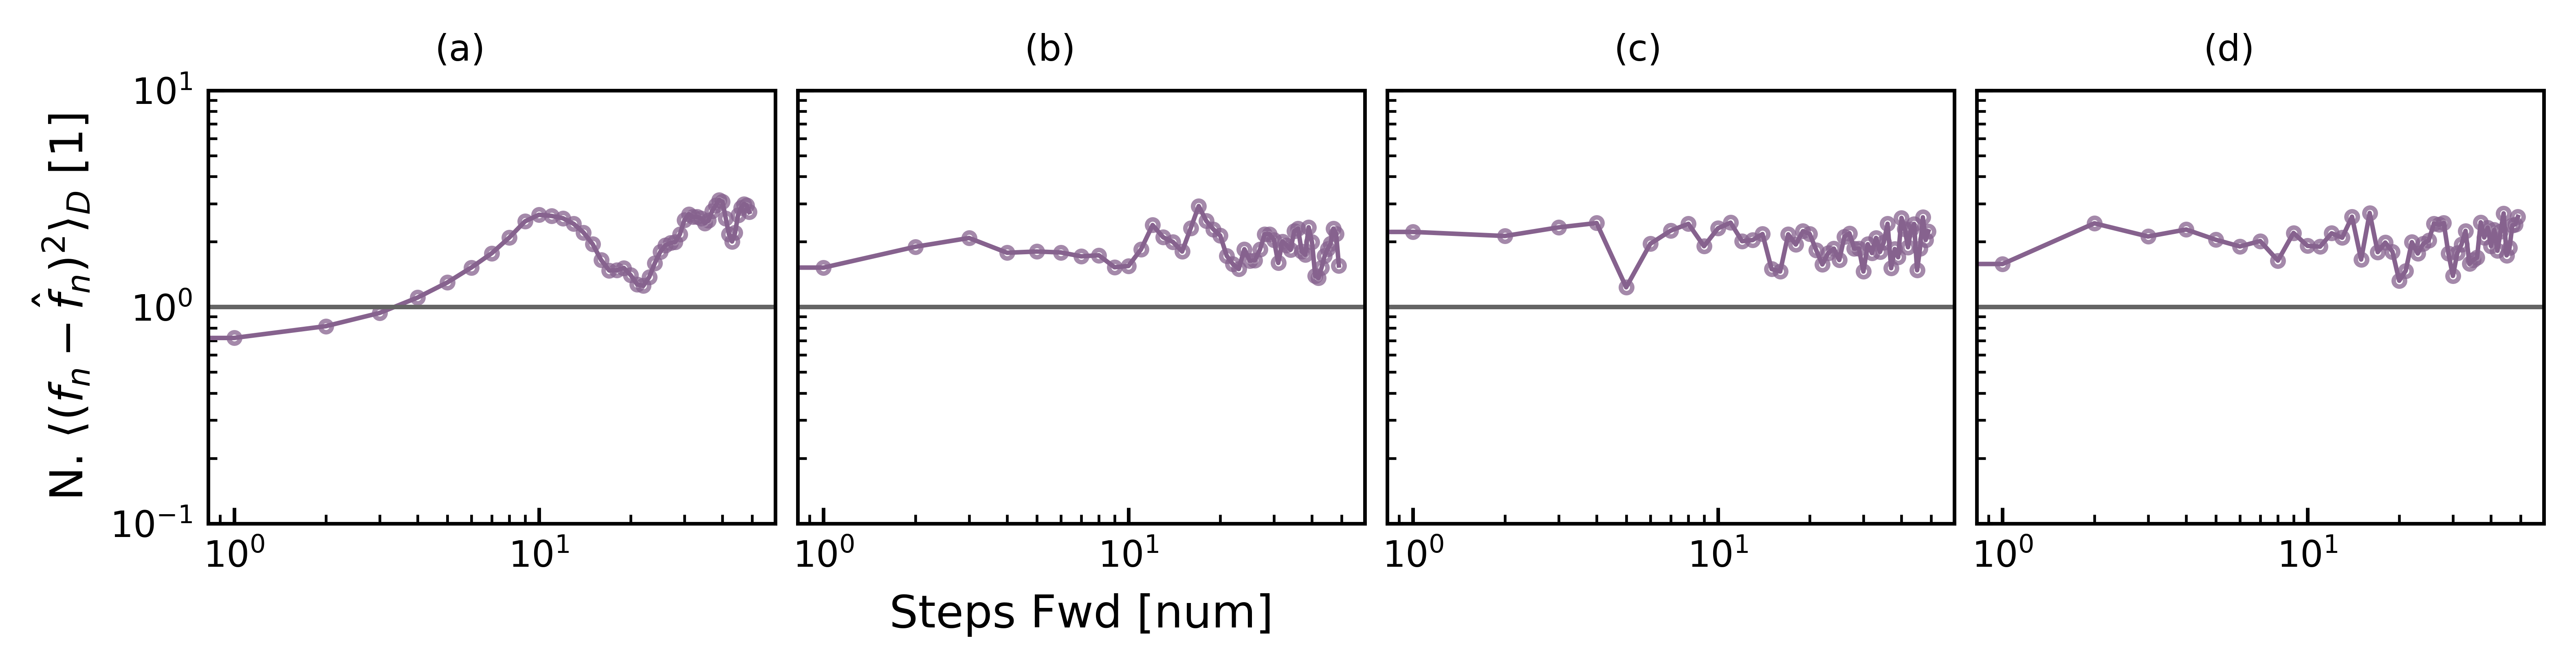

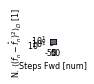

In [11]:
## Fig Setup
nrows = 1
ncols = 4


gs = gridspec.GridSpec(nrows, ncols,
                       left=0.08, right=0.99, 
                       top=0.9, bottom=0.15, 
                       wspace=0.04, hspace=0.65)

fig = plt.figure(figsize=(cm2inch(20.), cm2inch(4.5)), dpi=my_dpi)
dumpfig = plt.figure(figsize=(0.1, 0.1))
dumpax = dumpfig.add_subplot(111)

# Plot loss maps

for idx_c in xrange(len(variation_scan)):
    
    vars()['ax'+str(idx_c)+'_mean']  = fig.add_subplot(gs[0, idx_c])
    dumpax, vars()['ax'+str(idx_c)+'_mean'] = pnm(dumpax, vars()['ax'+str(idx_c)+'_mean'],  ALGO_LIST, 
                                           test_case, variation_scan[idx_c], 
                                           datapath,
                                           fstep=50, sstep=50, lowloss=20, 
                                           ylim = [-1, 1], yscale='log')
    

    vars()['ax'+str(idx_c)+'_mean'].text(0.4, 1.07, case_labels[idx_c], transform=vars()['ax'+str(idx_c)+'_mean'].transAxes)
    if idx_c !=0:
        vars()['ax'+str(idx_c)+'_mean'].set(title='', ylabel='', yticklabels=[])
    if idx_c !=1:
        vars()['ax'+str(idx_c)+'_mean'].set(xlabel='')
        
    vars()['ax'+str(idx_c)+'_mean'] = set_font_sizes(vars()['ax'+str(idx_c)+'_mean'], fsize, Fsize)

#fig.savefig(savefig+figname+'.svg', format='svg')
plt.show()
plt.close()

QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 1
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 2
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 3
QKF: Data Loaded? Yes
I am in RISK DICT and test case and variations are: 24 4


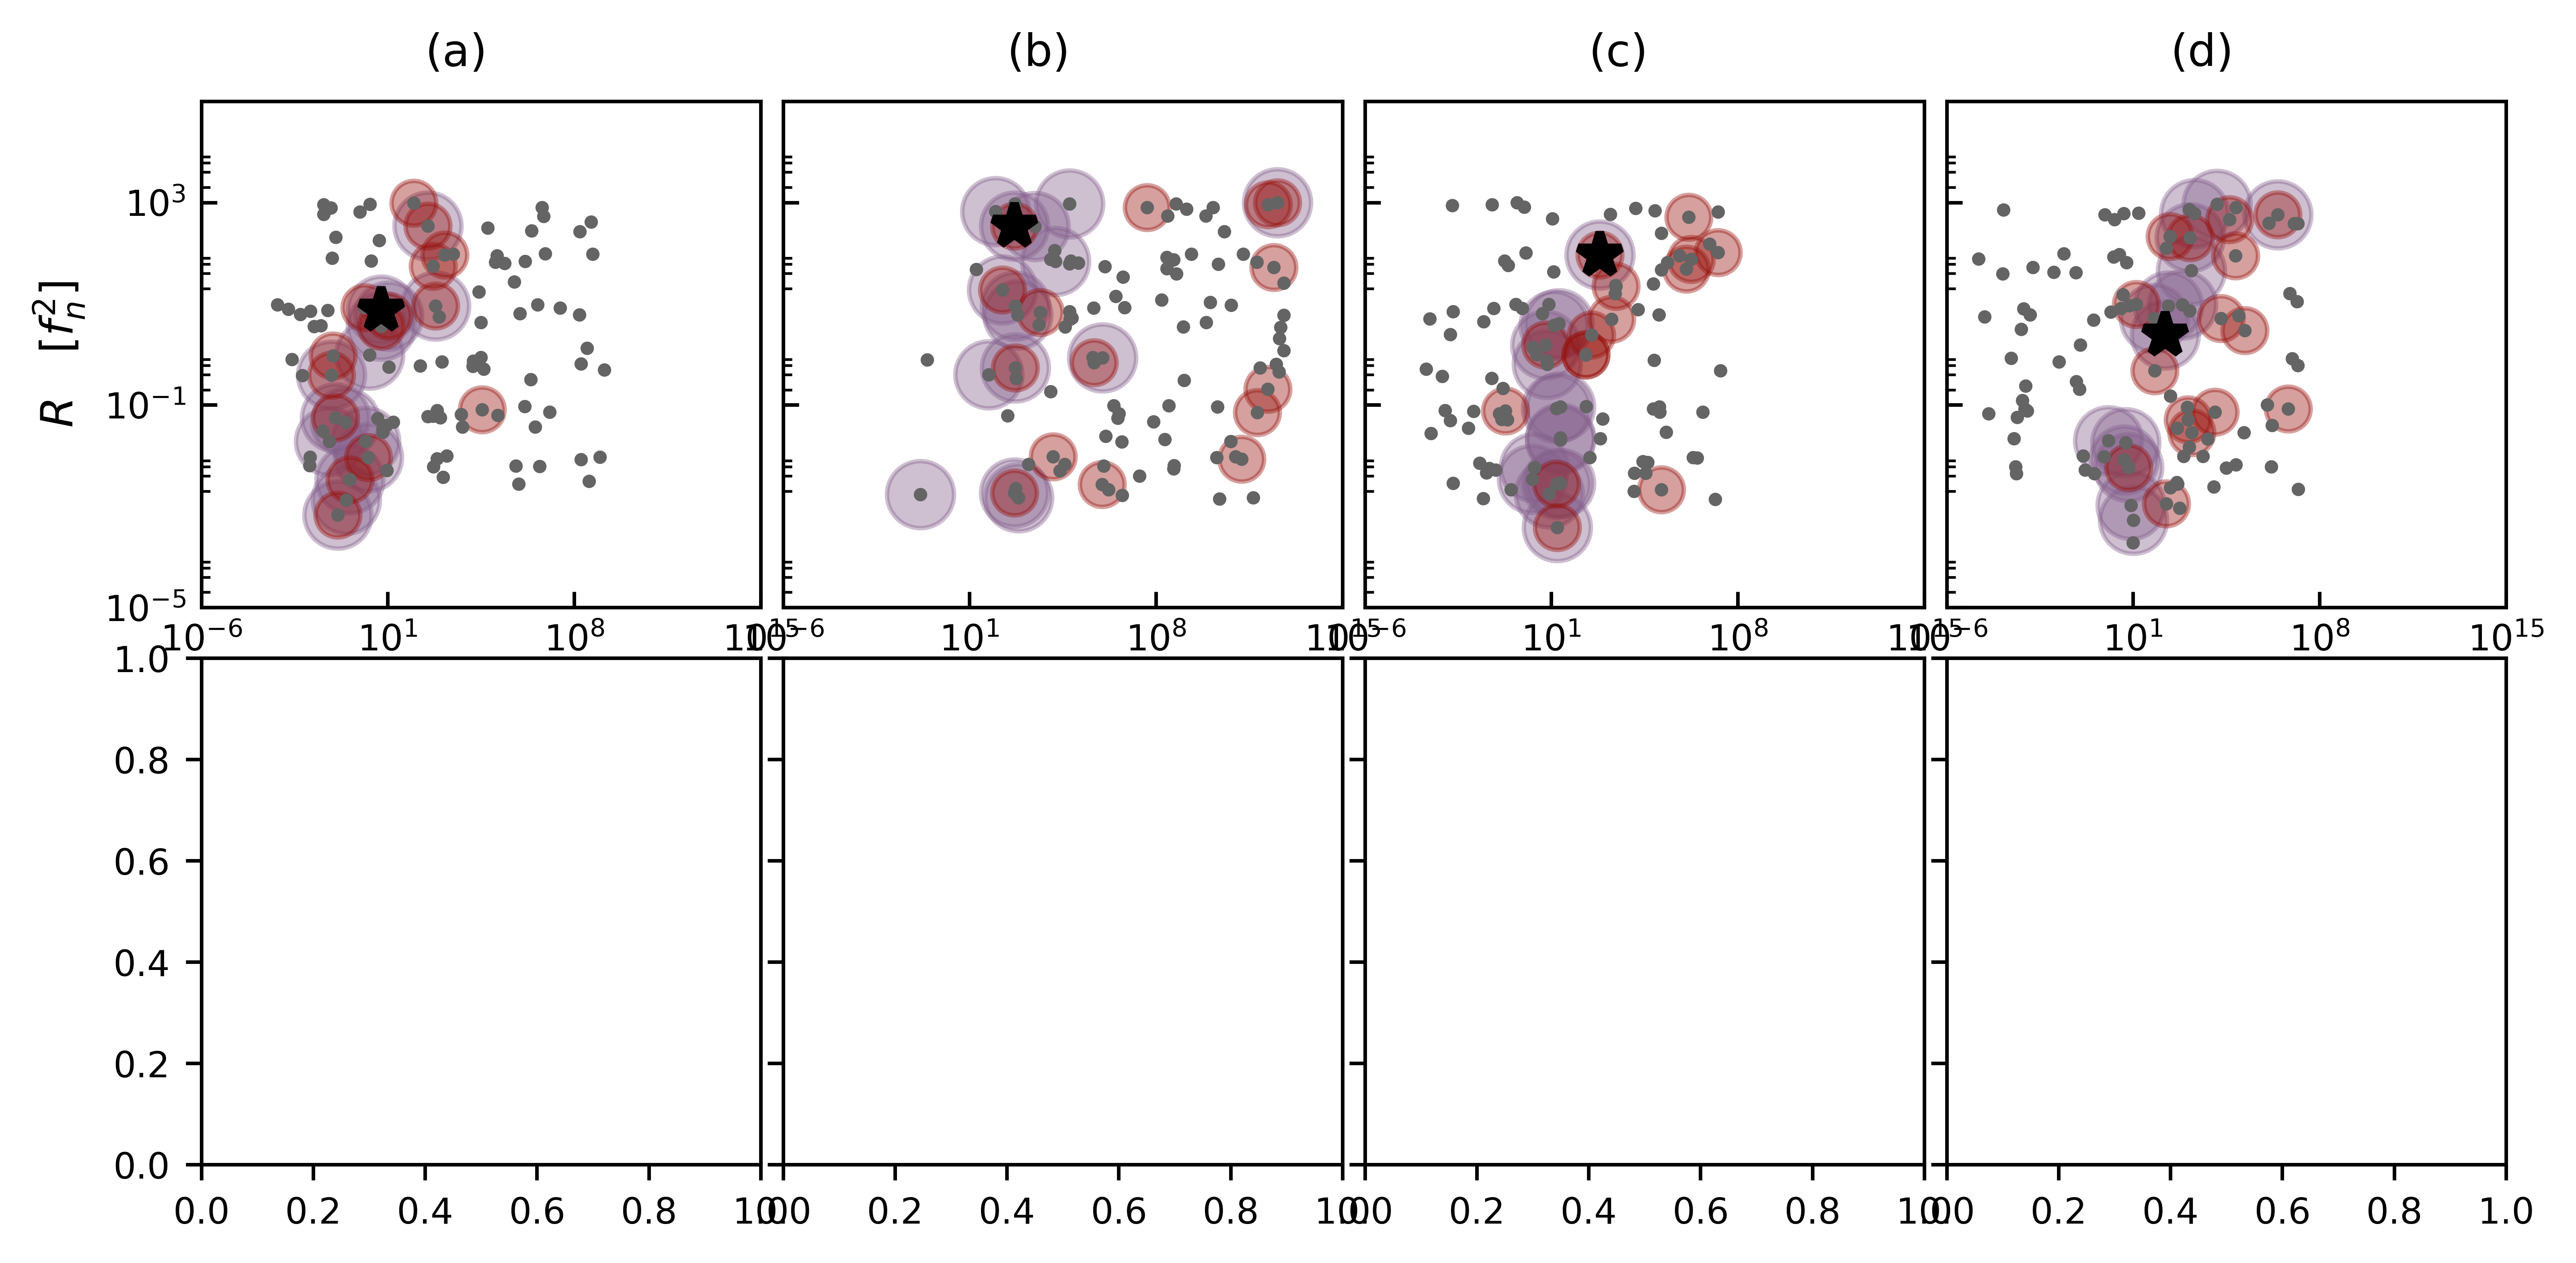

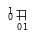

In [18]:
## Fig Setup
nrows = 2
ncols = 4
THRES=15
case_thres = ['10', '10', '10', '30']
case_thres_med_ratio_LKFFB = ['10', '10', '10', '30']
case_thres_med_ratio_AKF = ['10', '10', '10', '30']

gs = gridspec.GridSpec(nrows, ncols,
                       left=0.08, right=0.99, 
                       top=0.99, bottom=0.15, 
                       wspace=0.04, hspace=0.1)

fig = plt.figure(figsize=(cm2inch(20.), cm2inch(10.)), dpi=my_dpi)
dumpfig = plt.figure(figsize=(0.1, 0.1))
dumpax = dumpfig.add_subplot(111)

for idx_c in xrange(len(variation_scan)):
    
    vars()['ax'+str(idx_c)+'_1']  = fig.add_subplot(gs[0, idx_c])
    vars()['ax'+str(idx_c)+'_2']  = fig.add_subplot(gs[1, idx_c])
    
    vars()['ax'+str(idx_c)+'_1'], vars()['ax'+str(idx_c)+'_2'] = plot_risk_map_2(vars()['ax'+str(idx_c)+'_1'], 
                                                                                 ALGO_LIST, 
                      test_case, variation_scan[idx_c], datapath, lowloss=THRES,
                      figax2=vars()['ax'+str(idx_c)+'_2'], xlim=[-6, 15], ylim = [-5, 5])
    
    vars()['ax'+str(idx_c)+'_1'].text(0.4, 1.07, case_labels[idx_c], fontsize=Fsize, 
                                      #+r': $L^*<$ %s'%(case_thres[idx_c]), 
                                      transform=vars()['ax'+str(idx_c)+'_1'].transAxes)
    if idx_c !=0:
        vars()['ax'+str(idx_c)+'_1'].set(title='', xlabel='', ylabel='', yticklabels=[])
        vars()['ax'+str(idx_c)+'_2'].set(title='', xlabel='', ylabel='', yticklabels=[])
    vars()['ax'+str(0)+'_1'].set(title='', xlabel='')
    vars()['ax'+str(0)+'_2'].set(title='', ylabel='')
    
    for ax in [vars()['ax'+str(idx_c)+'_1'], vars()['ax'+str(idx_c)+'_2']]:
        ax = set_font_sizes(ax, fsize, Fsize)
    
    
#fig.savefig(savefig+figname+'_B.svg', format='svg')

plt.show()
plt.close()